In [29]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
def format_plot(name,show_axis=False):
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 144
    plt.rc('font', size=10)
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('xtick.major', size=4, width=1)
    plt.rc('ytick.major', size=4, width=1)
    plt.rc('axes', linewidth=1, labelsize='medium', titlesize='medium')
    if show_axis:
        plt.axhline(color='k', lw=0.5)
        plt.axvline(color='k', lw=0.5)
    plt.savefig(name, bbox_inches='tight')
    plt.show();


In [31]:
### WITH BOUNDARY CONDITIONS ###

# def applyDx(u):
#     # Applies the first derivative along the first dimension (rows)
#     Dx = np.diff(u, axis=0)
#     padding = np.zeros((1, u.shape[1]))
#     padding[0,-1] = 1
#     Dx = np.vstack([Dx, padding])
#     return Dx

# def applyDy(u):
#     # Applies the first derivative along the second dimension (columns)
#     Dy = np.diff(u, axis=1)
#     padding = np.zeros((u.shape[0], 1))
#     padding[-1,0] = 1
#     Dy = np.hstack([Dy, padding])
#     return Dy

###

def applyDx(u):
    # Applies the first derivative along the first dimension (rows)
    Dx = np.diff(u, axis=0)
    Dx = np.vstack([Dx, np.zeros((1, u.shape[1]))])
    return Dx

def applyDy(u):
    # Applies the first derivative along the second dimension (columns)
    Dy = np.diff(u, axis=1)
    Dy = np.hstack([Dy, np.zeros((u.shape[0], 1))])
    return Dy

def applyDxTrans(u):
    # Applies the transpose of the first derivative along the first dimension (rows)
    DxT = np.vstack([-u[0:1, :], -np.diff(u[:-1, :], axis=0), u[-2:-1, :]])
    return DxT

def applyDyTrans(u):
    # Applies the transpose of the first derivative along the second dimension (columns)
    DyT = np.hstack([-u[:, 0:1], -np.diff(u[:, :-1], axis=1), u[:, -2:-1]])
    return DyT

def laplacian(f,gamma=0):
    if not isinstance(gamma, np.ndarray):
        gamma = np.eye(f.shape[0])
    dxx = np.sqrt(gamma)@ applyDxTrans(np.sqrt(gamma)@applyDx(f))
    dyy = np.sqrt(gamma)@ applyDyTrans(np.sqrt(gamma)@applyDy(f))
    laplace_f = dxx + dyy
    
    return laplace_f.flatten()

In [32]:
def imblur(f,sigma,w,h):
    """Blurs an image using a gaussian filter"""
    Af = sp.ndimage.gaussian_filter(f.reshape((w,h)),sigma)
    return Af.flatten()

def ATA(f,alpha,sigma,w,h,reg_type,gamma=0):
    y = imblur(f,sigma,w,h)
    A_Ty = imblur(y,sigma,w,h)
    if reg_type == "tikhonov":
        z = A_Ty + alpha*f
    elif reg_type == "gradient":
        z = A_Ty + alpha*laplacian(f.reshape((w,h)),gamma)
    elif reg_type == "anisotropic":
        #z = A_Ty + alpha*(applyDxTrans(gamma*applyDx(f.reshape(w,h))).flatten()) +  alpha*(applyDyTrans(gamma*applyDy(f.reshape(w,h))).flatten())
        z = A_Ty + alpha*laplacian(f.reshape((w,h)),gamma)
    return z.reshape((-1,1))

def unblur_gmres(g,alpha,sigma,w,h,reg_type,callback=None,gamma=0):
    """
    Implements the GMRES solver for normal equations. 
    g is the blurred image to be reconstructed
    alpha is the regularisation parameter
    sigma is the blurring parameter passed to A (imblur(f))
    """
    M = g.size
    N = M
    ATg = imblur(g,sigma,w,h)
    A = sp.sparse.linalg.LinearOperator((M,N),
                                        matvec=lambda f: ATA(f,alpha,sigma,w,h,reg_type,gamma))
    gmresOutput = sp.sparse.linalg.gmres(A, ATg.flatten(),
                                         callback=callback,maxiter=2000) #gmres output
    f_alpha = gmresOutput[0]
    return f_alpha.reshape(w,h)

class counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))


def plot_deblur(f_unblurred,ftrue,g,sigma,plotname):
    w,h = ftrue.shape

    diff = f_unblurred - ftrue
    residual = g - imblur(f_unblurred,sigma,w,h)
    fig,ax = plt.subplots(1,3,figsize=(12,12))
    ax[0].imshow(g.reshape(w,h), cmap='gray')
    ax[0].set_title(f'Blurry image')
    ax[1].imshow(f_unblurred, cmap='gray')
    ax[1].set_title(f'Unblurred image')
    ax[2].imshow(residual.reshape(w,h), cmap='gray')
    ax[2].set_title('Residual $g-Af_{recon}$')
    

    format_plot(plotname);

In [33]:
### LSQR FUNCTIONS

def M_f(f,alpha,sigma,w,h,reg_type):
    Af = imblur(f,sigma,w,h)   
    if reg_type == "tikhonov":
        
        return np.concatenate((Af,np.sqrt(alpha)*f))
    
    elif reg_type == "gradient":
        Dx_f = applyDx(f.reshape(w,h)).flatten()
        Dy_f = applyDy(f.reshape(w,h)).flatten() 
        return np.concatenate((Af,np.sqrt(alpha)*Dx_f,np.sqrt(alpha)*Dy_f))


def MT_b(b,alpha,sigma,w,h,reg_type):
    if reg_type == "tikhonov":
        n = len(b)//2
        AT_b = imblur(b[:n],sigma,w,h)
        
        return  AT_b + np.sqrt(alpha)*b[n:]

    elif reg_type == "gradient":
        n = len(b)//3
        AT_b = imblur(b[:n],sigma,w,h) # because A = A_T, Ab == imblur(b)
        Dx_b = applyDxTrans(b[n:2*n].reshape(w,h)).flatten()
        Dy_b = applyDyTrans(b[2*n:].reshape(w,h)).flatten()
        
        return AT_b + np.sqrt(alpha)*Dx_b + np.sqrt(alpha)*Dy_b
    
def unblur_lsqr(g,alpha,sigma,w,h,reg_type,show=False):
    if reg_type == "tikhonov":
        b = np.vstack([np.reshape(g,(g.size,1)),np.zeros((g.size,1))])
        M,N = b.size,g.size

    elif reg_type == "gradient":
        b = np.vstack([np.reshape(g,(g.size,1)),np.zeros((g.size,1)),np.zeros((g.size,1))])
        M,N = b.size,g.size

    A = sp.sparse.linalg.LinearOperator((M,N),matvec = lambda f: M_f(f,alpha,sigma,w,h,reg_type), rmatvec = lambda b: MT_b(b,alpha,sigma,w,h,reg_type))
    lsqrOutput = sp.sparse.linalg.lsqr(A,b,show=show)
    f_lsqr = lsqrOutput[0]
    
    return f_lsqr.reshape(w,h)


## 1. A) & B)

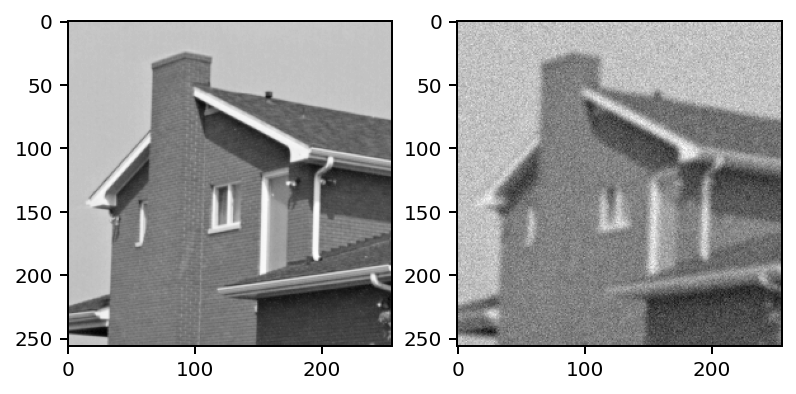

In [34]:
ftrue = plt.imread('house.png')
w,h = ftrue.shape
sigma = 2  # gaussian blur
theta = 0.05  # noise
alpha = 0.05  # regularisation

g = imblur(ftrue,sigma,w,h)
g = g + theta*np.random.randn(g.size)

fig,ax = plt.subplots(1,2)
ax[0].imshow(ftrue,cmap="gray")
ax[1].imshow(g.reshape(w,h),cmap="gray")
format_plot('1a')


## 1. C)

iter   1	rk = 0.02940954428406644
iter   2	rk = 0.009831304219761524


iter   3	rk = 0.004723390683929255
iter   4	rk = 0.002730999433984185
iter   5	rk = 0.0017093892220194312
iter   6	rk = 0.0011411312490198743
iter   7	rk = 0.000735255880222361
iter   8	rk = 0.00048335241121124847
iter   9	rk = 0.0003163527531496735
iter  10	rk = 0.00020408548234625046
iter  11	rk = 0.00013032432882756587
iter  12	rk = 8.38809480924445e-05
iter  13	rk = 5.415965650709188e-05
iter  14	rk = 3.4851854953914436e-05
iter  15	rk = 2.2270786644912646e-05
iter  16	rk = 1.4402501899586208e-05
iter  17	rk = 9.325271252604899e-06


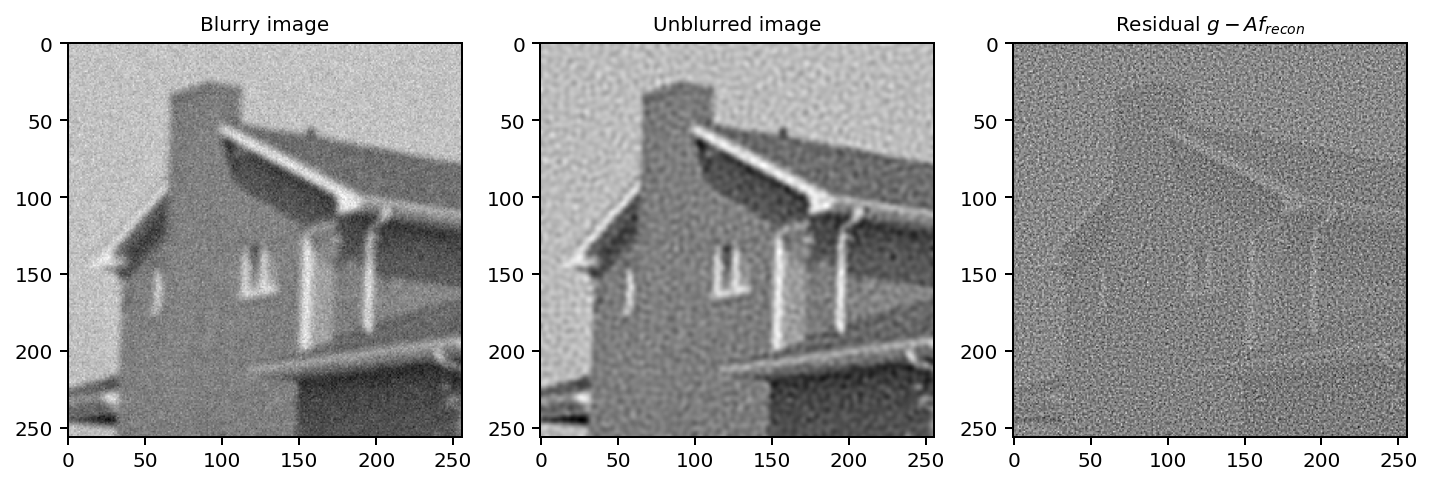

In [35]:
regulariser = "tikhonov"

f_alpha = unblur_gmres(g,alpha,sigma,w,h,regulariser,callback=counter())
plot_deblur(f_alpha,ftrue,g,sigma,'1c')

## 1. D)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 131072 rows and 65536 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =   131072
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.455e+02  1.455e+02    1.0e+00  6.8e-03
     1  6.95609e-01   3.464e+01  3.464e+01    2.4e-01  1.2e-01   1.0e+00  1.0e+00
     2  6.83774e-01   3.421e+01  3.421e+01    2.4e-01  3.4e-02   1.3e+00  2.1e+00
     3  6.81525e-01   3.414e+01  3.414e+01    2.3e-01  1.5e-02   1.5e+00  3.3e+00
     4  6.85156e-01   3.412e+01  3.412e+01    2.3e-01  8.6e-03   1.7e+00  4.7e+00
     5  6.91349e-01   3.411e+01  3.411e+01    2.3e-01  5.1e-03   1.8e+00  6.3e+00
     6  6.95072e-01   3.411e+01  3.411e+01    2.3e-01  3.3e-03   1.9e+00  8.0e+00
     7  6.96933e-01   3.411e+01  3.411e+01    2.3e-01  1.9e-03   2.1e+00  9.6e+00
     8  6.97597e-01   3.411e+01

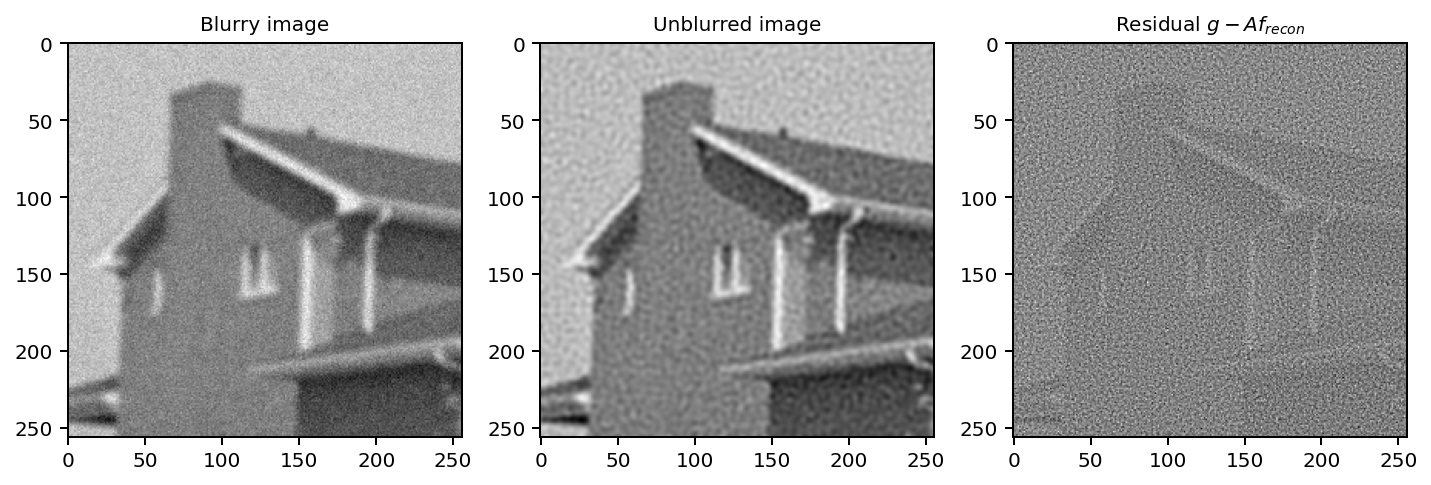

In [36]:
f_alpha = unblur_lsqr(g,alpha,sigma,w,h,regulariser,show=True)
plot_deblur(f_alpha,ftrue,g,sigma,'1d')

## 2. A) i. ii.

In [37]:
def DP(alpha, g, sigma,theta,w,h,method,reg_type):
    if method == 'gmres':
        fi = unblur_gmres(g,alpha,sigma,w,h,reg_type)
    elif method == 'lsqr':
        fi = unblur_lsqr(g,alpha,sigma,w,h,reg_type)

    r = g - imblur(fi,sigma,w,h)
    r_norm = np.linalg.norm(r)
    n = g.size
    dp = (r_norm**2 / n) - theta**2
    return dp

def dp_array(alphas,g,sigma,theta,w,h,method,reg_type):
    dp = np.zeros(len(alphas))
    for i, alpha in tqdm(enumerate(alphas)):
        dp_vals = DP(alpha,g,sigma,theta,w,h,method,reg_type)
        dp[i] = dp_vals 

    return dp

def L_curve(g, alpha, sigma,theta,w,h,method,reg_type):
    if method == 'gmres':
        fi = unblur_gmres(g,alpha,sigma,w,h,reg_type)
    elif method == 'lsqr':
        fi = unblur_lsqr(g,alpha,sigma,w,h,reg_type)
    fi_norm = np.linalg.norm(fi)
    r = g - imblur(fi,sigma,w,h)
    r_norm = np.linalg.norm(r)
    return fi_norm,r_norm

def L_array(alphas,g,sigma,theta,w,h,method,reg_type):
    r_norms = np.zeros(len(alphas))
    fi_norms = np.zeros(len(alphas))
    for i, alpha in tqdm(enumerate(alphas)):
        fi_norm,r_norm = L_curve(g,alpha,sigma,theta,w,h,method,reg_type)
        fi_norms[i],r_norms[i] = fi_norm,r_norm
    return fi_norms,r_norms

0it [00:00, ?it/s]

20it [00:02,  7.42it/s]


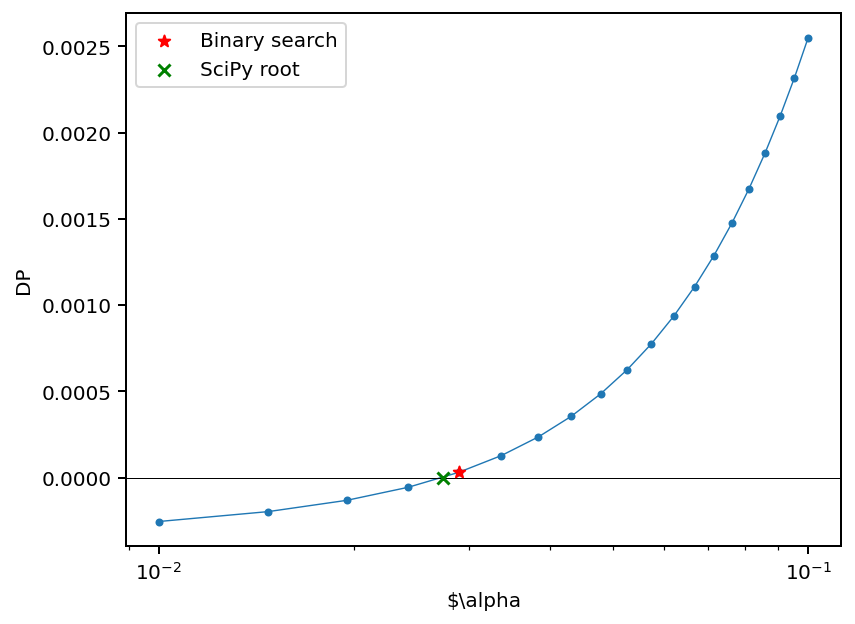

In [38]:
method = "gmres"
alphas = np.linspace(1e-2,1e-1,20)
dp = dp_array(alphas,g, sigma,theta,w,h,method,regulariser)

alpha_idx = min(range(len(dp)), key=lambda i: abs(dp[i]))
alpha_binarysearch = alphas[alpha_idx]

solution = sp.optimize.root(DP, 0.5e-2,args=(g,sigma,theta,w,h,method,regulariser))
if solution.success: 
    opt_alpha = solution.x[0]

plt.plot(alphas,dp,'.-',lw=0.7)
plt.scatter(alpha_binarysearch,dp[alpha_idx],c='r',marker="*",zorder=5,label="Binary search")
plt.scatter(opt_alpha,DP(opt_alpha,g,sigma,theta,w,h,method,regulariser),c="g",marker="x",zorder=10,label="SciPy root")
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel(r"$\alpha")
plt.ylabel("DP")
plt.legend()
format_plot('2i',show_axis=True)


12it [00:02,  4.24it/s]
12it [00:02,  4.59it/s]


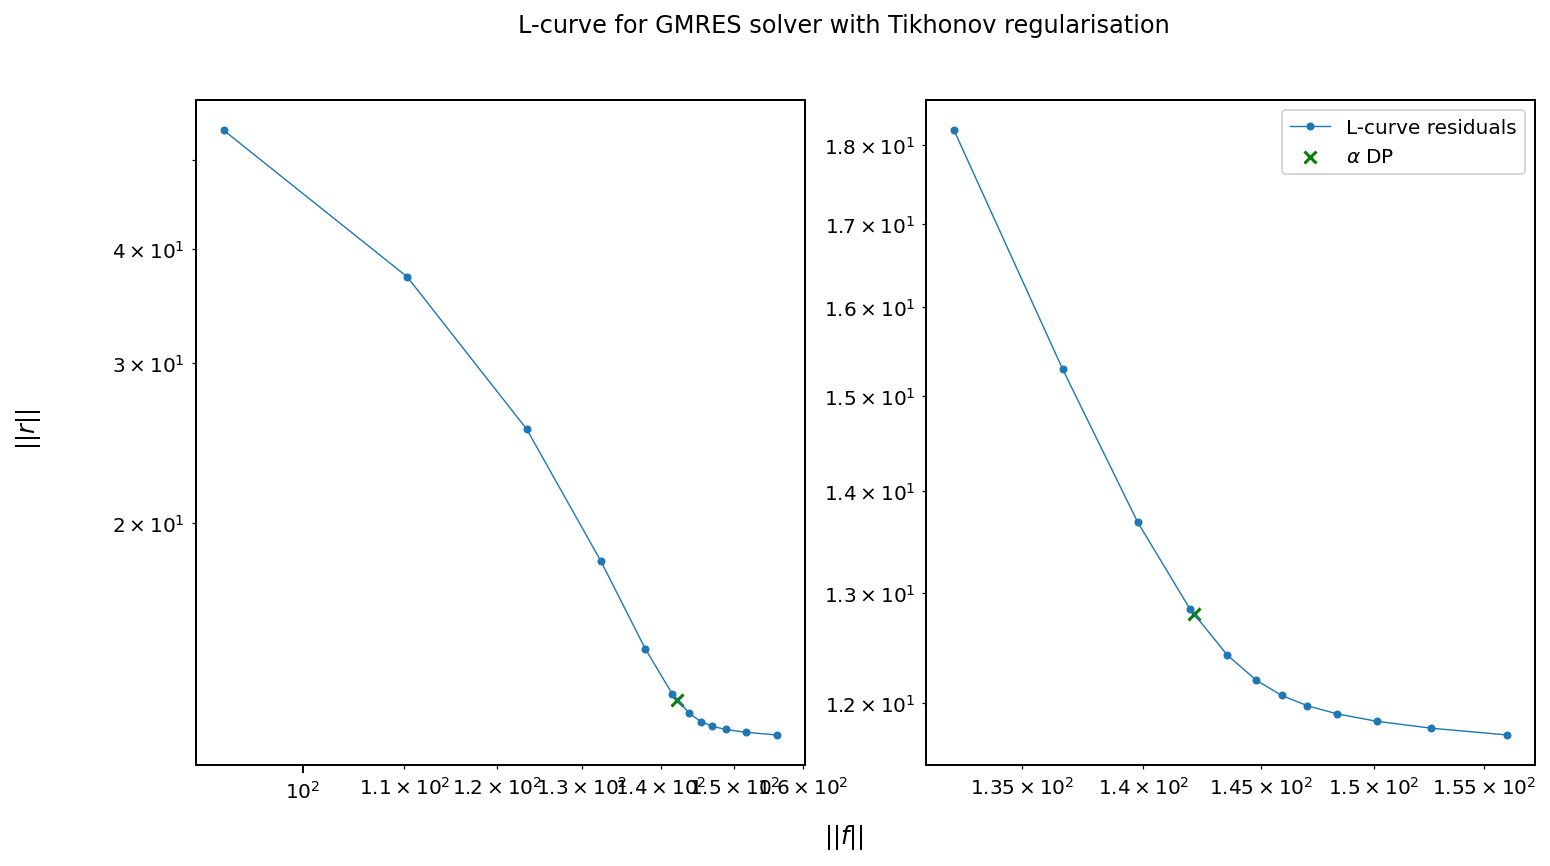

In [39]:
fi_norm_dp, r_norm_dp = L_curve(g, opt_alpha, sigma,theta,w,h,method,regulariser)

alphas = 10.0**np.arange(-3,0,0.25)
fi_norms,r_norms = L_array(alphas,g,sigma,theta,w,h,method,regulariser)
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].loglog(fi_norms,r_norms,'.-',lw=0.7)
ax[0].scatter(fi_norm_dp,r_norm_dp,c='g',marker='x',label=r"$\alpha$ DP")

alphas = 10.0**np.linspace(-3,-1,12)
fi_norms,r_norms = L_array(alphas,g,sigma,theta,w,h,method,regulariser)
ax[1].loglog(fi_norms,r_norms,'.-',lw=0.7,label = "L-curve residuals")
ax[1].scatter(fi_norm_dp,r_norm_dp,c='g',marker='x',label=r"$\alpha$ DP")

plt.legend()
fig.supxlabel(f'$||f||$')
fig.supylabel(f'$||r||$')
fig.suptitle("L-curve for GMRES solver with Tikhonov regularisation")
format_plot('2ii')

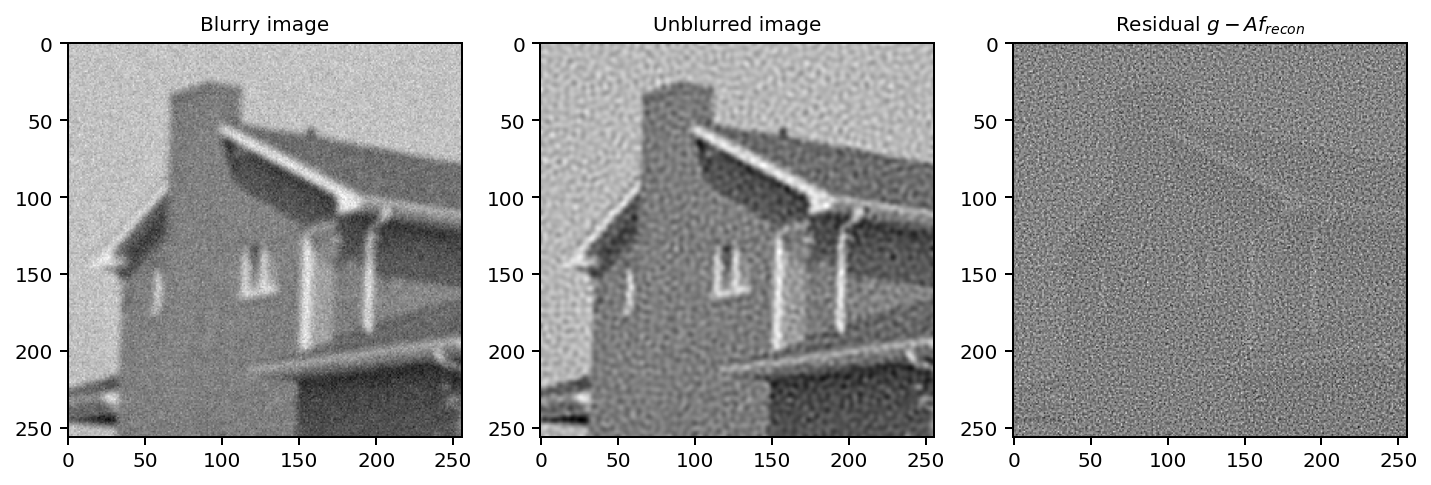

In [40]:
f_alpha = unblur_gmres(g,opt_alpha,sigma,w,h,"tikhonov")
plot_deblur(f_alpha,ftrue,g,sigma,"2iii")

## 3. A) & 3. B) i.

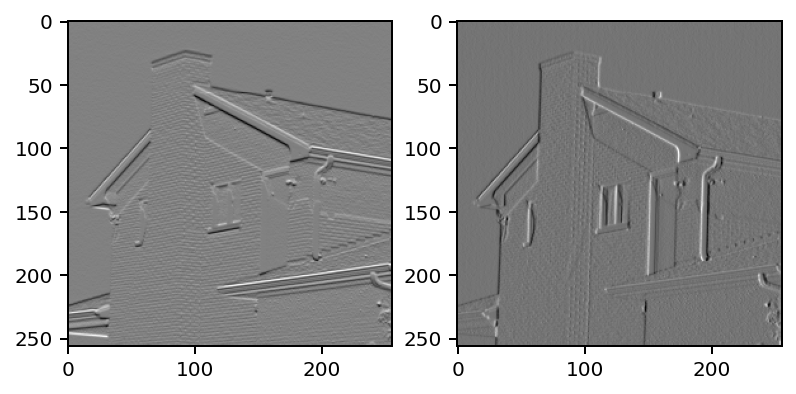

In [49]:
regulariser = "gradient"
fig,ax = plt.subplots(1,2)
ax[0].imshow(applyDx(ftrue.reshape(h,w)),cmap = "gray")
ax[1].imshow(applyDy(ftrue.reshape(h,w)),cmap = "gray")
format_plot('3a')

In [ ]:
f_alpha = unblur_gmres(g,alpha,sigma,w,h,regulariser,callback=counter())
plot_deblur(f_alpha,ftrue,g,sigma,'3bi')

## 3. B) ii.

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 196608 rows and 65536 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =   131072
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.455e+02  1.455e+02    1.0e+00  6.8e-03
     1  7.30471e-01   1.411e+01  1.411e+01    9.7e-02  3.1e-01   1.0e+00  1.0e+00
     2  7.17379e-01   1.287e+01  1.287e+01    8.8e-02  1.0e-01   1.3e+00  2.1e+00
     3  7.14398e-01   1.264e+01  1.264e+01    8.7e-02  4.7e-02   1.4e+00  3.3e+00
     4  7.18008e-01   1.257e+01  1.257e+01    8.6e-02  2.6e-02   1.6e+00  4.8e+00
     5  7.24632e-01   1.254e+01  1.254e+01    8.6e-02  1.5e-02   1.8e+00  6.3e+00
     6  7.28477e-01   1.253e+01  1.253e+01    8.6e-02  9.4e-03   1.9e+00  7.9e+00
     7  7.30319e-01   1.252e+01  1.252e+01    8.6e-02  5.2e-03   2.0e+00  9.5e+00
     8  7.30724e-01   1.252e+01

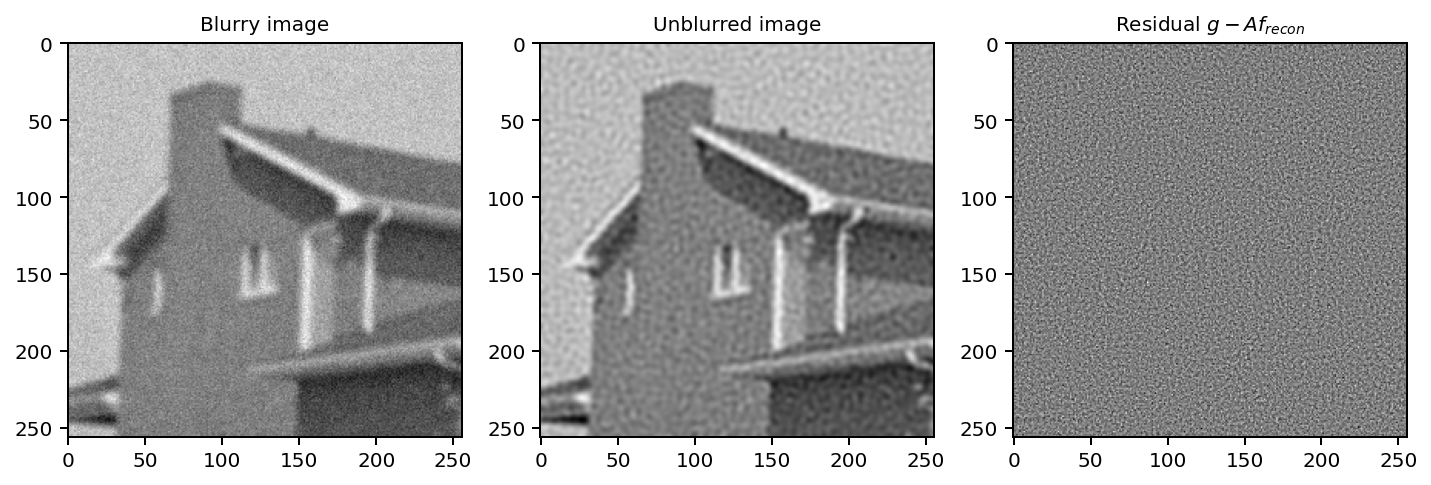

In [42]:
f_alpha = unblur_lsqr(g,alpha,sigma,w,h,regulariser,show=True)
plot_deblur(f_alpha,ftrue,g,sigma,'3bii')

## 3. C)

## 4.

In [43]:
def perona_malik(f):
    assert f.ndim > 1
    n = f.shape[0]
    Dx2 = np.square(applyDx(f))
    Dy2 = np.square(applyDy(f))
    T = np.sqrt(Dx2 + Dy2).max()
    gamma = np.exp(-np.sqrt(Dx2 + Dy2)/T)
    gamma = sp.sparse.spdiags(gamma.ravel(),diags=0,m=n,n=n).toarray()
    return gamma

iter   1	rk = 0.03045823053667794
iter   2	rk = 0.010597853146130681
iter   3	rk = 0.00528275733435704
iter   4	rk = 0.003138087979204216
iter   5	rk = 0.0020006172298395876
iter   6	rk = 0.0013559478836401417
iter   7	rk = 0.0008814950005155307
iter   8	rk = 0.0005728369354720059
iter   9	rk = 0.00037308266081224407
iter  10	rk = 0.00023887069952170984
iter  11	rk = 0.00015123685310182626
iter  12	rk = 9.535200452410545e-05
iter  13	rk = 6.0716918436175046e-05
iter  14	rk = 3.890846484334563e-05
iter  15	rk = 2.4630798620834885e-05
iter  16	rk = 1.5570618820806207e-05
iter  17	rk = 9.990806302857693e-06


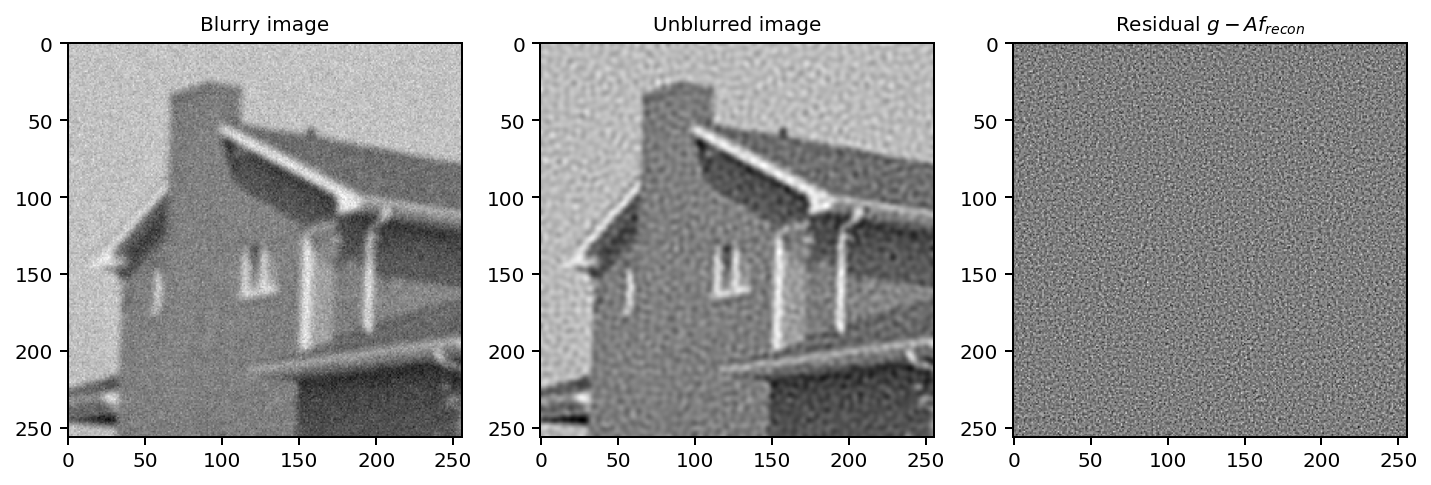

In [44]:
regulariser = "anisotropic"
gamma=perona_malik(g.reshape(w,h))
f_alpha = unblur_gmres(g,alpha,sigma,w,h,regulariser,callback=counter(),gamma=gamma)
plot_deblur(f_alpha,ftrue,g,sigma,'4')

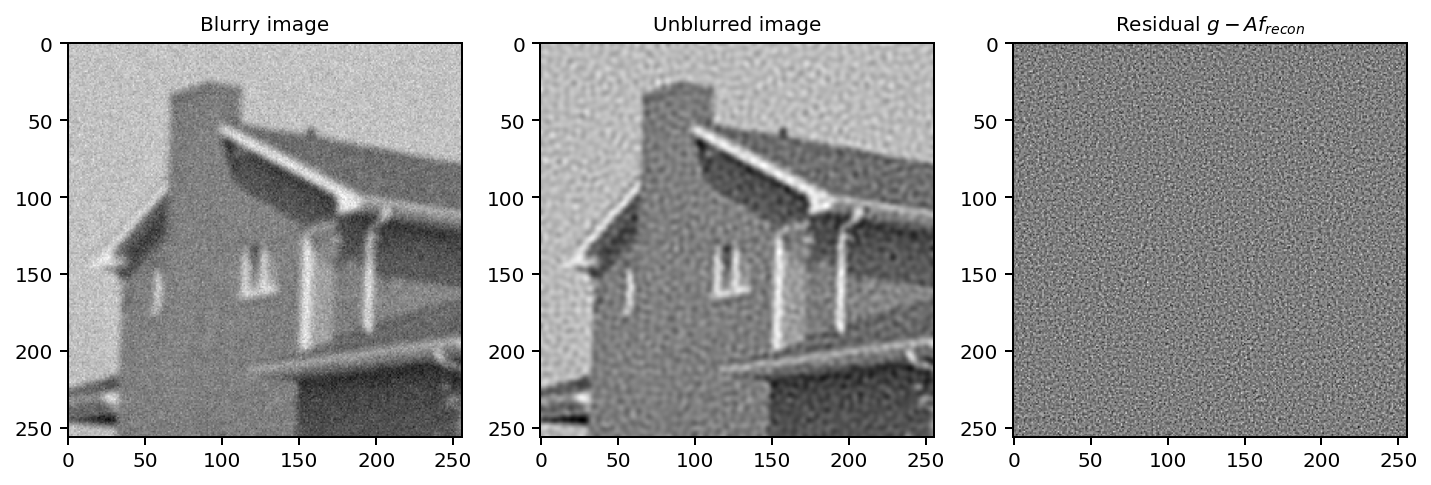

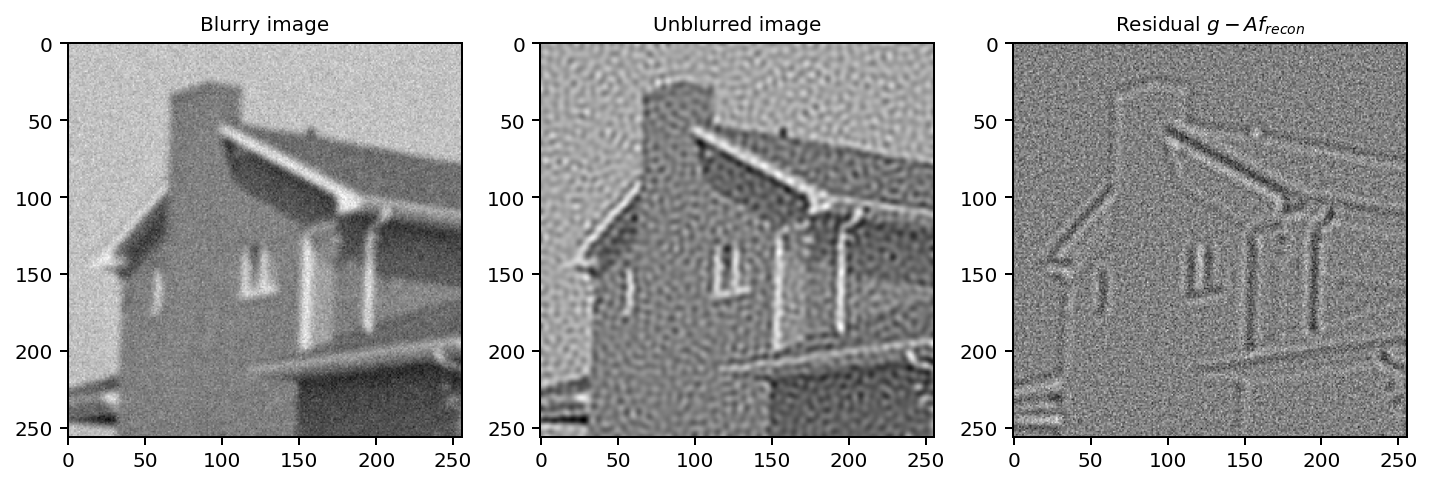

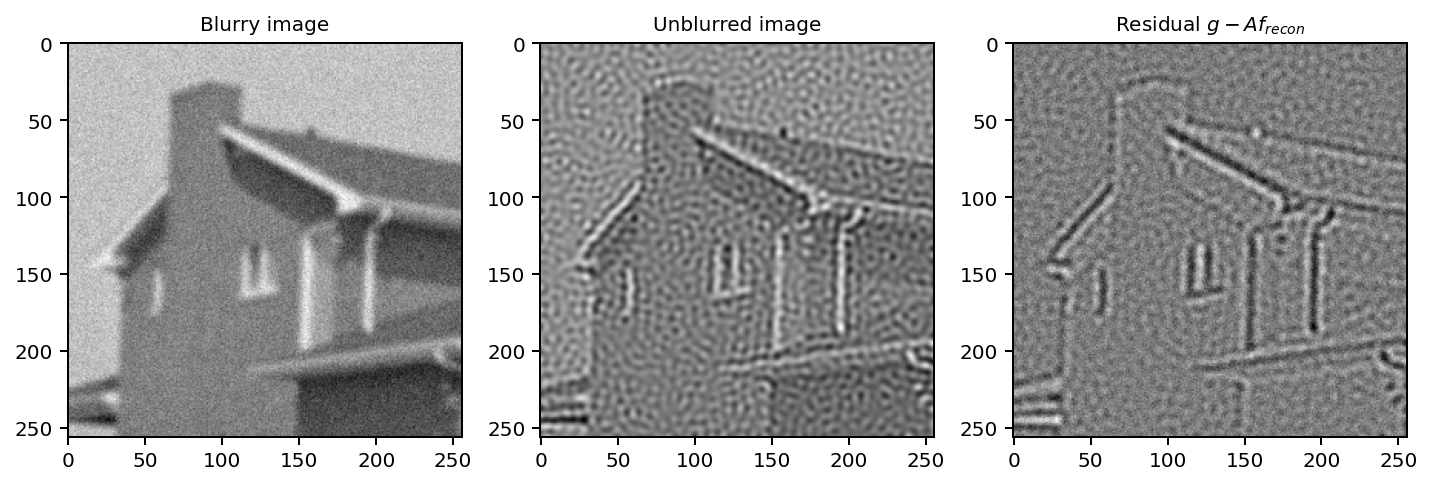

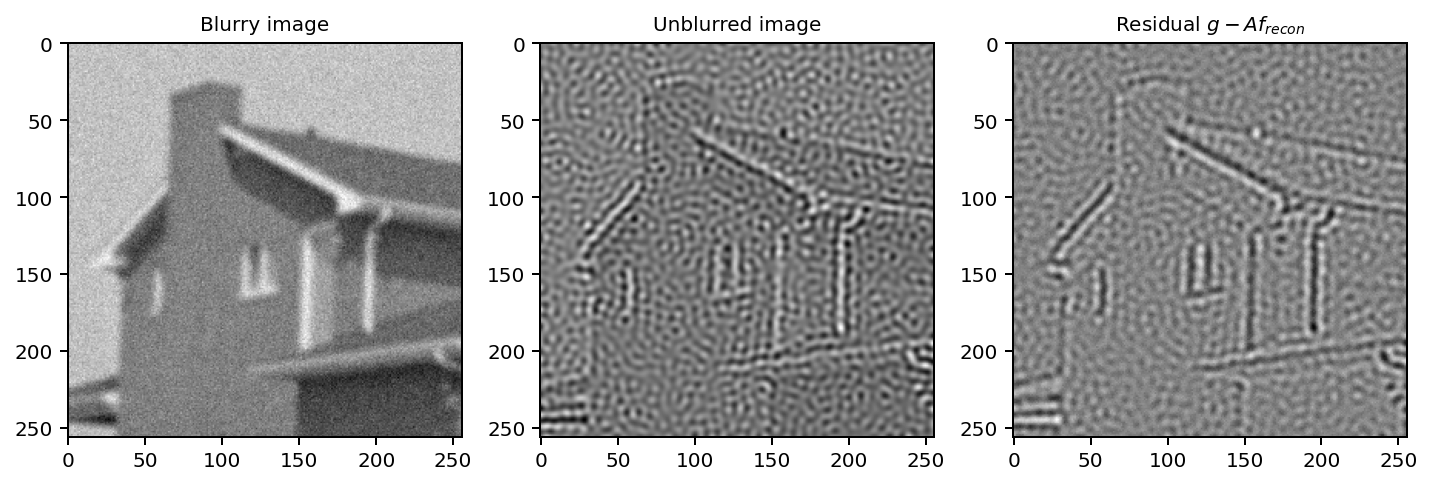

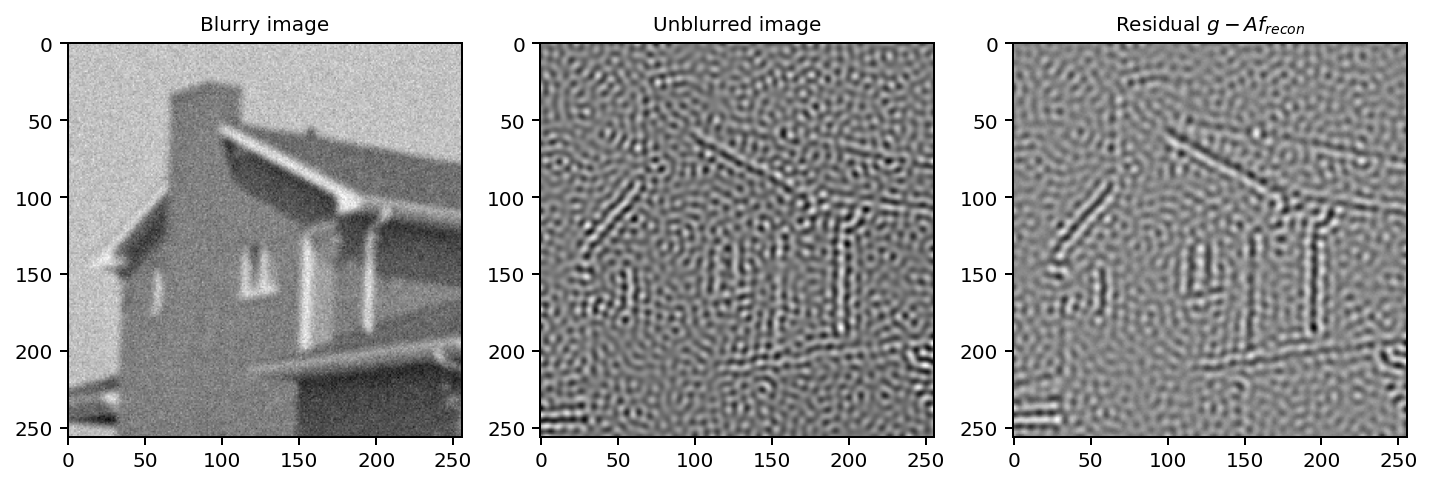

In [45]:
fi = g

for i in range(5):
    gamma=perona_malik(fi.reshape(w,h))
    fi = unblur_gmres(fi,alpha,sigma,w,h,regulariser,gamma=gamma)
    plot_deblur(fi,ftrue,g,sigma,'5i')